## Antithetic + Control Variates for Asian Option

In this notebook, we combine two powerful variance reduction techniques, Antithetic Variates and Control Variates, to estimate the price of an Asian option more efficiently.

- Antithetic Variates reduce variance by using negatively correlated paths.  
- Control Variates reduce variance by correcting with a known expected value (European call price).

Combining them helps produce a more accurate and stable option price estimate.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
np.random.seed(42)

# Parameters
S0 = 100      # Initial stock price
K = 100       # Strike price
r = 0.05      # Risk-free rate
T = 1.0       # Time to maturity
sigma = 0.2   # Volatility
M = 50        # Time steps
N = 10000     # Number of simulations

In [2]:
# Simulating GBM paths for Antithetic Variates for Asian Options

def asian_antithetic_paths(S0, K, r, T, sigma, M = 50, N = 10000):
    dt = T / M
    S_paths = np.zeros((2*N, M+1))
    S_paths[:, 0] = S0

    for t in range(1, M+1):
        Z = np.random.randn(N)
        Z_anti = -Z

        # Normal Paths
        S_paths[:N, t] = S_paths[:N, t-1] * np.exp((r - 0.5 * sigma**2) * dt + (sigma * np.sqrt(dt) * Z))
        
        # Antithetic Paths
        S_paths[N:, t] = S_paths[N:, t-1] * np.exp((r - 0.5 * sigma**2) * dt + (sigma * np.sqrt(dt) * Z_anti))

    return S_paths

In [3]:
S_paths = asian_antithetic_paths(S0=100, K=100, r=0.05, T=1, sigma=0.2, M = 50, N = 10000)

### Compute Payoffs

We now compute the payoffs for both Asian and European call options:

- **Asian Option Payoff**: Based on the average price over the path.
- **European Option Payoff**: Based on the terminal price (S_T), to be used as a control variate.
- Both are discounted to present value using e^{-rT}.

In [4]:
def compute_asian_and_european_payoffs(S_paths, K, r, T):

    average_price = np.mean(S_paths[:, 1:], axis = 1)
    S_T = S_paths[:, -1]

    # Asian Call Discounted Payoffs
    asian_payoff = np.exp(-r * T) * np.maximum(average_price - K, 0)

    # European Call Discounted Payoffs
    euro_payoff = np.exp(-r * T) * np.maximum(S_T - K, 0)

    return asian_payoff, euro_payoff

In [5]:
asian_payoff, euro_payoff = compute_asian_and_european_payoffs(S_paths, 100, 0.05, 1)

### Combine Antithetic and Control Variates

To improve pricing accuracy further, we apply **control variates** on top of the antithetic paths.

- The European call payoff is used as the control variate because its expected value is known (Black-Scholes).
- We calculate the covariance between Asian and European payoffs and apply the control variate adjustment:
  
Adjusted Payoff = Asian Payoff + c (BS European Price - European Payoff)

This reduces variance and improves estimate quality.

In [6]:
def price_asian_with_antithetic_control(S_path, S0, K, r, T, sigma):

    # European Black Scholes Price (Estimated Known price)
    d1 = (np.log(S0/K) + (r + 0.5 * sigma**2) * T) / sigma * np.sqrt(T)
    d2 = d1 - sigma * np.sqrt(T)
    bs_price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

    # Compute Payoffs
    asian_payoff, euro_payoff = compute_asian_and_european_payoffs(S_paths, K, r, T)

    # Compute Optimal Coeficient c
    c = np.cov(asian_payoff, euro_payoff)[0,1] /np.var(euro_payoff)

    # Apply Control Variate Adjustment
    adjusted_price = asian_payoff + c * (bs_price - euro_payoff)

    # Return estimated price and diagnostics
    asian_price = np.mean(adjusted_price)
    std_plain = np.std(asian_payoff)
    std_control = np.std(adjusted_price)

    return asian_price, std_plain, std_control

    

In [7]:
S_paths = asian_antithetic_paths(S0=100, K=100, r=0.05, T=1, sigma=0.2, M=50, N=5000)
asian_price, std_plain, std_control = price_asian_with_antithetic_control(S_paths, S0=100, K=100, r=0.05, T=1, sigma=0.2)

print(f"Asian Option Price (CV + AV): {asian_price:.4f}")
print(f"Standard Deviation (Plain) : {std_plain:.4f}")
print(f"Standard Deviation (Control): {std_control:.4f}")

Asian Option Price (CV + AV): 5.8326
Standard Deviation (Plain) : 8.0843
Standard Deviation (Control): 4.3325


## Final Summary: Variance Reduction for Asian Options

In this section, we priced a path-dependent **Asian Call Option** using **Monte Carlo simulation** and applied two advanced **variance reduction techniques**:

### 1. Antithetic Variates:
- Generated antithetic paths by simulating both \( Z \) and \( -Z \).
- Reduced randomness and improved estimate stability.

### 2. Control Variates:
- Used European Call option as a control, since its price is known via Black-Scholes.
- Applied the adjustment:
  
Adjusted Payoff = Asian Payoff + c(BS Price - European Payoff)

### Result:
- **Asian Option Price**: 5.8326
- **Standard Deviation (Plain)**: 8.0843  
- **Standard Deviation (After Control Variate)**: 4.3325

> ✅ We successfully reduced variance by combining both techniques, making the simulation more efficient and reliable.

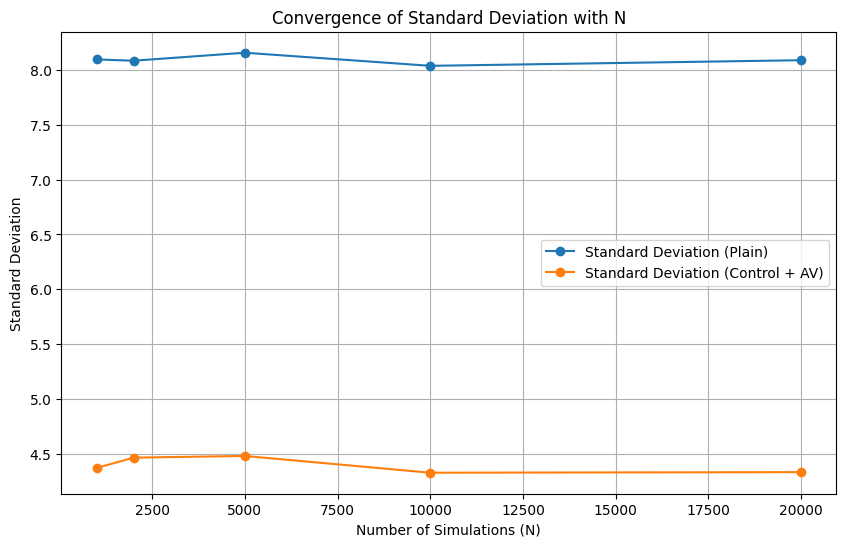

In [8]:
Ns = [1000, 2000, 5000, 10000, 20000]
plain_stds = []
control_stds = []

for N in Ns:
    S_paths = asian_antithetic_paths(S0=100, K=100, r=0.05, T=1, sigma=0.2, M=50, N=N)
    _, std_plain, std_control = price_asian_with_antithetic_control(S_paths, 100, 100, 0.05, 1, 0.2)
    plain_stds.append(std_plain)
    control_stds.append(std_control)

plt.figure(figsize=(10,6))
plt.plot(Ns, plain_stds, label="Standard Deviation (Plain)", marker='o')
plt.plot(Ns, control_stds, label="Standard Deviation (Control + AV)", marker='o')
plt.xlabel("Number of Simulations (N)")
plt.ylabel("Standard Deviation")
plt.title("Convergence of Standard Deviation with N")
plt.legend()
plt.grid(True)
plt.show()